In [1]:
import chromadb
import time

import jsonlines
from tqdm.notebook import tqdm
from collections import defaultdict

from matplotlib import pyplot as plt

import polars as pl
import pandas as pd
import numpy as np

from code.fasttext.embedding_utils import TableEncoder, compare_embeddings
from code.utils.utils import rebuild_table
from code.utils.settings import DefaultPath

In [2]:
tabenc = TableEncoder ()

In [4]:
chroma_client = chromadb.PersistentClient(
    DefaultPath.db_path.chroma + 'double_collection_v1/' + 'v_29_25000_add_label_False_with_metadatas_True'
    )
chroma_client.list_collections()

[Collection(name=columns), Collection(name=rows)]

In [5]:
row_collection = chroma_client.get_collection('rows')
column_collection = chroma_client.get_collection('columns')

In [6]:
sloth_results = pl.read_csv(DefaultPath.data_path.wikitables + 'train_set_turl_malaguti.csv') \
                    .sort(by=['o_a', 'jsim', 'a%'], descending=[True, True, True])

In [7]:
def get_from_jsonl_table_df(table_id: str):
    with jsonlines.open(DefaultPath.data_path.wikitables + 'sloth_tables.jsonl') as reader:
        while (json_table := reader.read())['_id'] != table_id:
            continue
        return rebuild_table(json_table)

In [8]:
with jsonlines.open(DefaultPath.data_path.wikitables + 'sloth_tables.jsonl') as reader:
    sloth_tables_ids = {json_table['_id'] for i, json_table in enumerate(reader) if i < 25000}

In [10]:
# version 1 - pre-load all tables
# in_db = sloth_results[['r_id', 's_id']].apply(lambda x: x[0] in sloth_tables.keys() and x[1] in sloth_tables.keys())
# sloth_results = sloth_results.with_columns(pl.Series(name='in-db', values=in_db)).filter(pl.col('in-db') == True).drop('in-db')

# version 2 - on-demand loading
in_db = sloth_results[['r_id', 's_id']].apply(lambda x: x[0] in sloth_tables_ids and x[1] in sloth_tables_ids)
sloth_results = sloth_results.with_columns(pl.Series(name='in-db', values=in_db)).filter(pl.col('in-db') == True).drop('in-db')

In [11]:
sloth_results.head()

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491
"""16517223-1""","""16519520-1""",0.915589,1640,0.622627
"""16682980-1""","""16717744-1""",0.863576,1590,0.600907
"""16559174-1""","""16682980-1""",0.842894,1465,0.549925
"""16519520-1""","""16559174-1""",0.867637,1345,0.51063


# Computing the similarity mean to rank the tables

## Test 1: Low Jaccard - High Overlap

In [12]:
idx_row = 0
sloth_result_rec = sloth_results[idx_row]
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491


In [13]:
r_id = sloth_result_rec['r_id'].item()
s_id = sloth_result_rec['s_id'].item()
r_table = get_from_jsonl_table_df(r_id) # sloth_tables[r_id]
s_table = get_from_jsonl_table_df(s_id) # sloth_tables[s_id]

r_row_embeddings, r_column_embeddings = tabenc.full_embedding(r_table, True)
r_row_embeddings.shape, r_column_embeddings.shape 

((265, 300), (7, 300))

In [14]:
r_table.head()

,Name,Rural municipality (RM),Population (2011),Population (2006),Change (%),Land area (km²),Population density (per km²)
0,Abbey,Miry Creek No. 229,115,130,-11.5,0.77,149.1
1,Abernethy,Abernethy No. 186,196,197,-0.5,1.03,189.9
2,Albertville,Wise Creek No. 77,140,110,27.3,1.12,124.7
3,Alida,Reciprocity No. 32,131,106,23.6,0.37,357.1
4,Alvena,Fish Creek No. 402,55,55,0,0.43,128


In [15]:
s_table.head()

,Name,Status,Rural municipality,Population (2011),Population (2006),Change (%),Land area (km²),Population density (per km 2 )
0,Estevan,City,Estevan No. 5,11054,10084,9.6,18.85,586.6
1,Flin Flon (part),City,—,"229 This population does not include 5,363 in ...",242,-5.4,2.37 This area does not include km2 (sqmi) in ...,96.4
2,Humboldt,City,Humboldt No. 370,5678,4998,13.6,13.46,421.9
3,Lloydminster (part) The balance of Lloydminste...,City,Britannia No. 502,"9772 This population does not include 18,032 i...",8118,20.4,17.34 This area does not include km2 (sqmi) in...,563.6
4,Martensville Martensville is Saskatchewan's sm...,City,Corman Park No. 344,7716,4978,55,6.23,1239.3


### Row querying

In [16]:
res = row_collection.query(
    query_embeddings=r_row_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [17]:
row_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        row_tid_freq_simlist[single_rec['table_id']].append(res['distances'][i][j])

In [18]:
row_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), row_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
row_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True, ignore_index=True)
row_freq_avgcos_df = row_freq_avgcos_df[row_freq_avgcos_df['freq'] > 1].reset_index().drop('index', axis=1)
row_freq_avgcos_df.head(10)

,table_id,freq,avg-cosine-distance
0,30307073-2,2,0.015381
1,1650910-2,3,0.015790
2,3310797-3,4,0.015809
3,1650901-2,2,0.015842
4,16332699-1,2,0.016801
5,16709873-2,2,0.017015
6,23890542-5,2,0.017039
7,3149882-1,2,0.017543
8,40305504-5,3,0.017564
9,35838476-2,2,0.017569


In [25]:
s_rec = row_freq_avgcos_df[row_freq_avgcos_df['table_id'] == s_id]
s_id_idx = int(s_rec.index.values)
s_rec

,table_id,freq,avg-cosine-distance
310,37953453-1,1742,0.036194


In [ ]:
get_from_jsonl_table_df(row_freq_avgcos_df.loc[s_id_idx, 'table_id'])

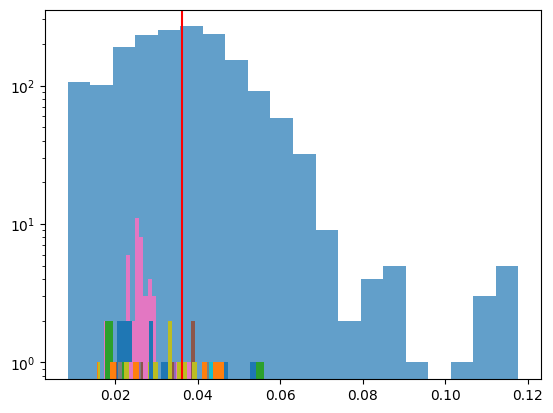

In [28]:
plt.yscale('log')
plt.hist(row_tid_freq_simlist[row_freq_avgcos_df.loc[s_id_idx, 'table_id']], bins=20, alpha=0.7)
for idx in range(0, s_id_idx - 1, 10):
    plt.hist(row_tid_freq_simlist[row_freq_avgcos_df.loc[idx, 'table_id']], bins=20)

plt.axvline(x=row_freq_avgcos_df.loc[s_id_idx, 'avg-cosine-distance'], color='r')
plt.show()

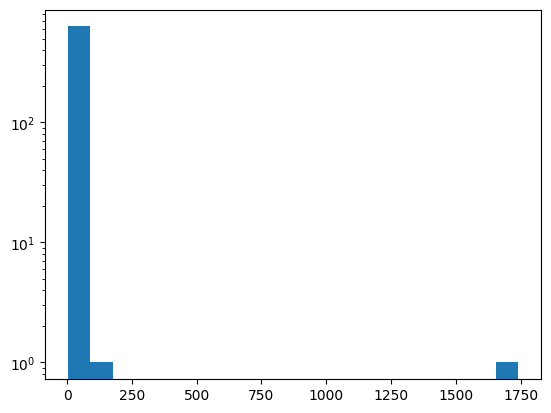

In [48]:
plt.yscale('log')
plt.hist(row_freq_avgcos_df['freq'], bins=20, rwidth=1)
plt.show()

### Column querying

In [29]:
col_res = column_collection.query(
    query_embeddings=r_column_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [30]:
col_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(col_res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        col_tid_freq_simlist[single_rec['table_id']].append(col_res['distances'][i][j])

In [39]:
col_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), col_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
col_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)

# discarding tables which appears only once, since they aren't actually significative
col_freq_avgcos_df = col_freq_avgcos_df[col_freq_avgcos_df['freq'] > 1].reset_index().drop('index', axis=1)
col_freq_avgcos_df.head()

,table_id,freq,avg-cosine-distance
0,20010164-2,4,0.001202
1,5116633-1,2,0.001346
2,33895892-8,2,0.001476
3,37953453-1,9,0.002961
4,10848656-1,2,0.005462


In [40]:
col_freq_avgcos_df[col_freq_avgcos_df['table_id'] == s_id]

,table_id,freq,avg-cosine-distance
3,37953453-1,9,0.002961


<Axes: >

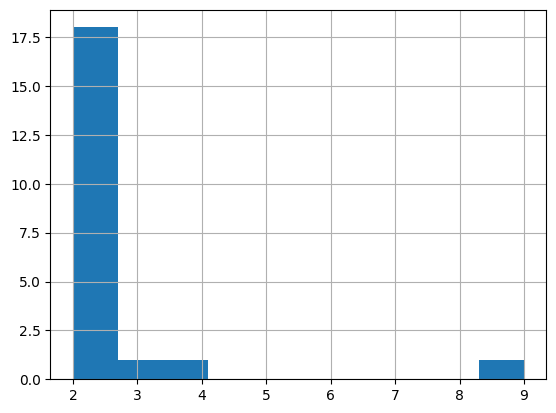

In [41]:
col_freq_avgcos_df['freq'].hist()

### Conclusions

In [49]:
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491


Nonostante la jsim molto bassa, anche in questo caso nel ranking sia tra colonne che tra righe la s_table di partenza è prima se si considera innnanzitutto la frequenza come fattore di ordinamento, altrimenti con la cosine distance media è comunque tra le prime

Come relazionare bene eventualmente questi due parametri?

## Test 2: High Jaccard - High Overlap

In [50]:
sloth_results[10:20]

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""8246204-5""","""8246204-8""",0.666667,588,0.913043
"""33589658-1""","""33589658-2""",0.7875,540,0.952381
"""40275491-1""","""40275563-1""",0.931579,504,0.965517
"""16288618-2""","""16288731-3""",0.744186,484,0.768254
"""16288306-2""","""16288618-2""",0.754098,462,0.785714
"""36630062-1""","""40275491-1""",0.658824,462,0.885057
"""23266117-5""","""37438685-5""",1.0,451,1.0
"""29361244-2""","""29361282-2""",0.798165,440,0.785714
"""16288224-2""","""16288306-2""",0.765217,429,0.766071


In [51]:
idx_row = 12
sloth_result_rec = sloth_results[idx_row]
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""40275491-1""","""40275563-1""",0.931579,504,0.965517


In [52]:
r_id = sloth_result_rec['r_id'].item()
s_id = sloth_result_rec['s_id'].item()
r_table = get_from_jsonl_table_df(r_id) # sloth_tables[r_id]
s_table = get_from_jsonl_table_df(s_id) # sloth_tables[s_id]

r_row_embeddings, r_column_embeddings = tabenc.full_embedding(r_table, True)
r_row_embeddings.shape, r_column_embeddings.shape 

((174, 300), (3, 300))

In [ ]:
r_table.sample(5)

,State,Defence minister,Party
37,Comoros,,
94,Lebanon,,
1,Albania,,
60,France,,
165,United States,Treasury Secretary Chuck Hagel,Republican


In [53]:
s_table.sample(5)

,State,Interior minister,Party
65,Ghana,,
58,Fiji,,
24,Brunei,,
101,Macedonia,,
156,Slovakia,,


### Row querying

In [54]:
res = row_collection.query(
    query_embeddings=r_row_embeddings.tolist(),
    n_results=10,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [55]:
row_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        row_tid_freq_simlist[single_rec['table_id']].append(res['distances'][i][j])

In [56]:
row_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), row_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
row_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)
row_freq_avgcos_df = row_freq_avgcos_df[row_freq_avgcos_df['freq'] > 1]
row_freq_avgcos_df.head(10)

,table_id,freq,avg-cosine-distance
40,11963783-1,2,0.175682
36,325218-1,2,0.201609
4,39598332-1,44,0.227124
0,37799969-8,36,0.233921
2,12739506-4,37,0.234216
1,29417661-2,38,0.234331
3,24254496-1,256,0.242562
5,19291505-1,149,0.248328
33,40275563-1,8,0.255610
23,1973157-2,7,0.261315


In [57]:
s_rec = row_freq_avgcos_df[row_freq_avgcos_df['table_id'] == s_id]
s_id_idx = int(s_rec.index.values)
s_rec

,table_id,freq,avg-cosine-distance
33,40275563-1,8,0.25561


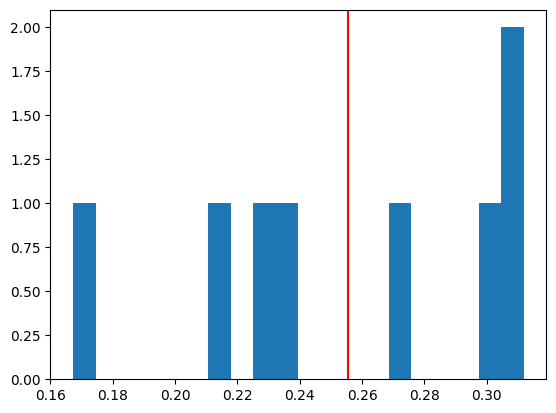

In [58]:
plt.hist(row_tid_freq_simlist[row_freq_avgcos_df.loc[s_id_idx, 'table_id']], bins=20)
plt.axvline(x=row_freq_avgcos_df.loc[s_id_idx, 'avg-cosine-distance'], color='r')
plt.show()

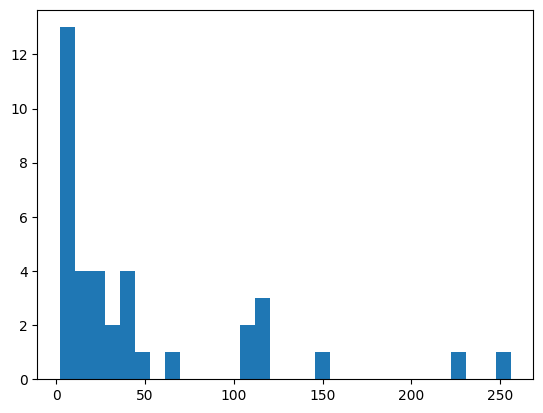

In [60]:
plt.hist(row_freq_avgcos_df['freq'], bins=30)
plt.show()

In [65]:
row_freq_avgcos_df[row_freq_avgcos_df['freq'] > 100]

,table_id,freq,avg-cosine-distance
3,24254496-1,256,0.242562
5,19291505-1,149,0.248328
6,78455-12,226,0.294262
9,308781-7,105,0.309271
8,78443-4,116,0.311521
7,40286332-1,120,0.311884
15,22212487-3,114,0.325860
14,22225468-4,108,0.328051


In [62]:
get_from_jsonl_table_df(row_freq_avgcos_df.loc[3, 'table_id']).head()

,Member,Party,Notes
0,Yosef Almogi,Mapai,
1,Zalman Aran,Mapai,
2,Meir Argov,Mapai,
3,Ami Assaf,Mapai,
4,David Bar-Rav-Hai,Mapai,


In [63]:
get_from_jsonl_table_df(row_freq_avgcos_df.loc[6, 'table_id']).head()

,North Division,South Division
0,Oregon,Arizona
1,Oregon State,Arizona State
2,Washington,Colorado
3,Washington State,Utah
4,California,UCLA


In [64]:
r_table.head()

,State,Defence minister,Party
0,Afghanistan,,
1,Albania,,
2,Algeria,,
3,Andorra,,
4,Angola,,


### Column querying

In [66]:
col_res = column_collection.query(
    query_embeddings=r_column_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [67]:
col_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(col_res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        col_tid_freq_simlist[single_rec['table_id']].append(col_res['distances'][i][j])

In [69]:
col_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), col_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
col_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)

# all the tables has at most frequency 1!!!
# col_freq_avgcos_df[col_freq_avgcos_df['freq'] > 1].head()
col_freq_avgcos_df.head()

,table_id,freq,avg-cosine-distance
0,40275563-1,1,0.000147
1,10826158-1,1,0.001405
2,325218-1,1,0.001563
3,26443006-1,1,0.001648
4,38018425-1,1,0.001744


In [71]:
s_id

'40275563-1'

### Conclusions

In [72]:
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""40275491-1""","""40275563-1""",0.931579,504,0.965517


## Test 3: Low Jaccard - Low Overlap

In [ ]:
sloth_results[:10]

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""14342092-1""","""37953453-1""",0.55753,1778,0.958491
"""16517223-1""","""16519520-1""",0.915589,1640,0.622627
"""16682980-1""","""16717744-1""",0.863576,1590,0.600907
"""16559174-1""","""16682980-1""",0.842894,1465,0.549925
"""16519520-1""","""16559174-1""",0.867637,1345,0.51063
"""16517223-1""","""16559174-1""",0.81258,1190,0.449735
"""16519520-1""","""16682980-1""",0.750777,1030,0.39104
"""16517223-1""","""16682980-1""",0.717855,910,0.343915
"""16517223-1""","""16717744-1""",0.657429,729,0.27551


In [73]:
idx_row = 9
sloth_result_rec = sloth_results[idx_row]
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""269064-2""","""3881235-1""",0.474112,640,0.302172


In [74]:
r_id = sloth_result_rec['r_id'].item()
s_id = sloth_result_rec['s_id'].item()
r_table = get_from_jsonl_table_df(r_id) # sloth_tables[r_id]
s_table = get_from_jsonl_table_df(s_id) # sloth_tables[s_id]

r_row_embeddings, r_column_embeddings = tabenc.full_embedding(r_table, True)
r_row_embeddings.shape, r_column_embeddings.shape 

((755, 300), (4, 300))

In [75]:
r_table.head()

,Lord,Party,Type,Notes
0,The Lord Aberdare,Crossbench,Excepted hereditary peer,
1,The Baroness Adams of Craigielea,Labour,Life peer,
2,The Lord Addington,Liberal Democrat,Excepted hereditary peer,
3,The Lord Adebowale,Crossbench,Life peer,Member of the Advisory Council on the Misuse o...
4,The Lord Adonis,Labour,Life peer,Former Secretary of State for Transport


In [76]:
s_table.head()

,Title,Creation,Other titles
0,The Lord Chalfont,1964,
1,The Baroness Masham of Ilton,1970,
2,The Lord Tanlaw,1971,
3,The Baroness Sharples,1973,
4,The Lord Mackie of Benshie,1974,


### Row querying

In [77]:
res = row_collection.query(
    query_embeddings=r_row_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [78]:
row_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        row_tid_freq_simlist[single_rec['table_id']].append(res['distances'][i][j])

In [79]:
row_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), row_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
row_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)
row_freq_avgcos_df = row_freq_avgcos_df[row_freq_avgcos_df['freq'] > 1]
row_freq_avgcos_df.head()

,table_id,freq,avg-cosine-distance
0,5943114-1,635,0.330173
58,31800753-59,2,0.341039
80,1258197-1,3,0.347006
3,20461378-3,527,0.349394
20,19285466-5,208,0.355047


In [82]:
s_id

'3881235-1'

In [83]:
s_id in row_freq_avgcos_df['table_id']

False

<Axes: >

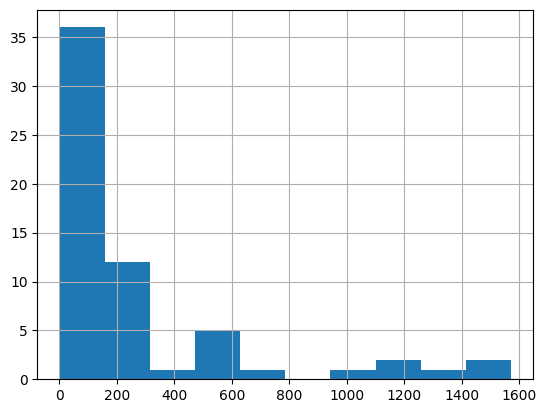

In [84]:
row_freq_avgcos_df['freq'].hist()

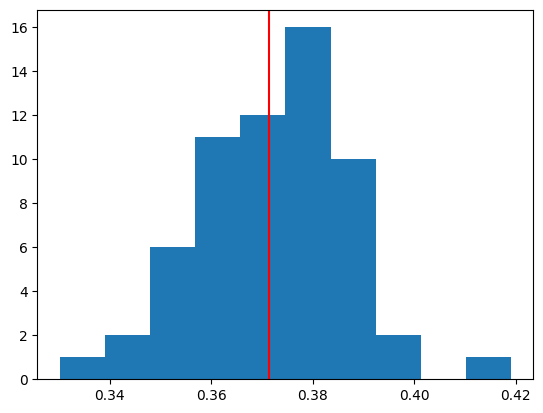

In [90]:
plt.hist(row_freq_avgcos_df['avg-cosine-distance'])
plt.axvline(np.mean(row_freq_avgcos_df['avg-cosine-distance']), color='r')
plt.show()

In generale, qui la similarità media è piuttosto bassa...

### Column querying

In [91]:
col_res = column_collection.query(
    query_embeddings=r_column_embeddings.tolist(),
    n_results=20,
    include=['metadatas', 'distances'],
    where={'table_id': {'$ne': r_id}}
)

In [92]:
col_tid_freq_simlist = defaultdict(list)
for i, res_metadatas in enumerate(col_res['metadatas']):
    for j, single_rec in enumerate(res_metadatas):
        col_tid_freq_simlist[single_rec['table_id']].append(col_res['distances'][i][j])

In [94]:
col_freq_avgcos_df = pd.DataFrame(
    list(map(lambda t: (t[0], len(t[1]), sum(t[1])/len(t[1])), col_tid_freq_simlist.items())), columns=['table_id', 'freq', 'avg-cosine-distance']
    )
col_freq_avgcos_df.sort_values(by=['avg-cosine-distance', 'freq'], ascending=[True, False], inplace=True)

# discarding tables which appears only once, since they aren't actually significative
# there isn't any table with freq>1!!!
# col_freq_avgcos_df[col_freq_avgcos_df['freq'] > 1].head()
col_freq_avgcos_df.head()

,table_id,freq,avg-cosine-distance
20,93961-2,1,0.023283
21,31585511-1,1,0.023283
22,31386331-1,1,0.023283
23,9536531-18,1,0.044121
24,9536531-4,1,0.044121


In [97]:
s_id in col_freq_avgcos_df['table_id']

False

Anche qua la s_table non rientra nemmeno tra i match trovati...

### Conclusions

In [99]:
sloth_result_rec

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""269064-2""","""3881235-1""",0.474112,640,0.302172
